# fbb scheleton notebook for PUI2016 HW6
# Completed by: Jonathan Toy @jontoy

In [224]:
from __future__ import print_function, division
import numpy as np
import geopandas as gpd
import pandas as pd
import pylab as pl
import datetime
import urllib
import os
import json
import zipfile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time


#s = json.load( open(os.getenv('PUI2016')+'_jt2276/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
#if os.getenv("PUIDATA") is None:
#    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [227]:
#download, and move data to PUIDATA, and read data in 
!curl -O "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD"
time.sleep(2)
!mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv $PUIDATA/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv
nrg = pd.read_csv(os.getenv('PUIDATA') + '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
!rm -f rows.csv?accessType=DOWNLOAD
    
!curl -O "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip"

time.sleep(2)
# code taken from http://stackoverflow.com/questions/3451111/unzipping-files-in-python
zip_ref = zipfile.ZipFile('mn_mappluto_16v1.zip', 'r')
zip_ref.extractall(os.getenv('PUIDATA') + '/mn_mappluto_16v1')
zip_ref.close()

bsize = gpd.read_file(os.getenv('PUIDATA') + '/mn_mappluto_16v1/MNMapPLUTO.shp')
!mv mn_mappluto_16v1.zip $PUIDATA/mn_mappluto_16v1.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  1905k      0 --:--:--  0:00:01 --:--:-- 2105k
mv: cannot stat `Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  29.0M      0 --:--:-- --:--:-- --:--:-- 44.7M
mv: setting attribute `security.selinux' for `security.selinux': Permission denied


In [228]:
nrg.columns

Index(['Record Number', 'NYC Borough, Block, and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

In [217]:
bsize.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

In [218]:
# make sure you clean up your data and throw away columns you do not need!
nrg = nrg[['NYC Borough, Block, and Lot (BBL)','Zip Code', 'Site EUI(kBtu/ft2)',
          'DOF Property Floor Area (Buildngs and Parking)(ft2)','DOF Number of Buildings']]
bsize = bsize[['BBL','UnitsTotal']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96c0967f60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f96c199d710>]], dtype=object)

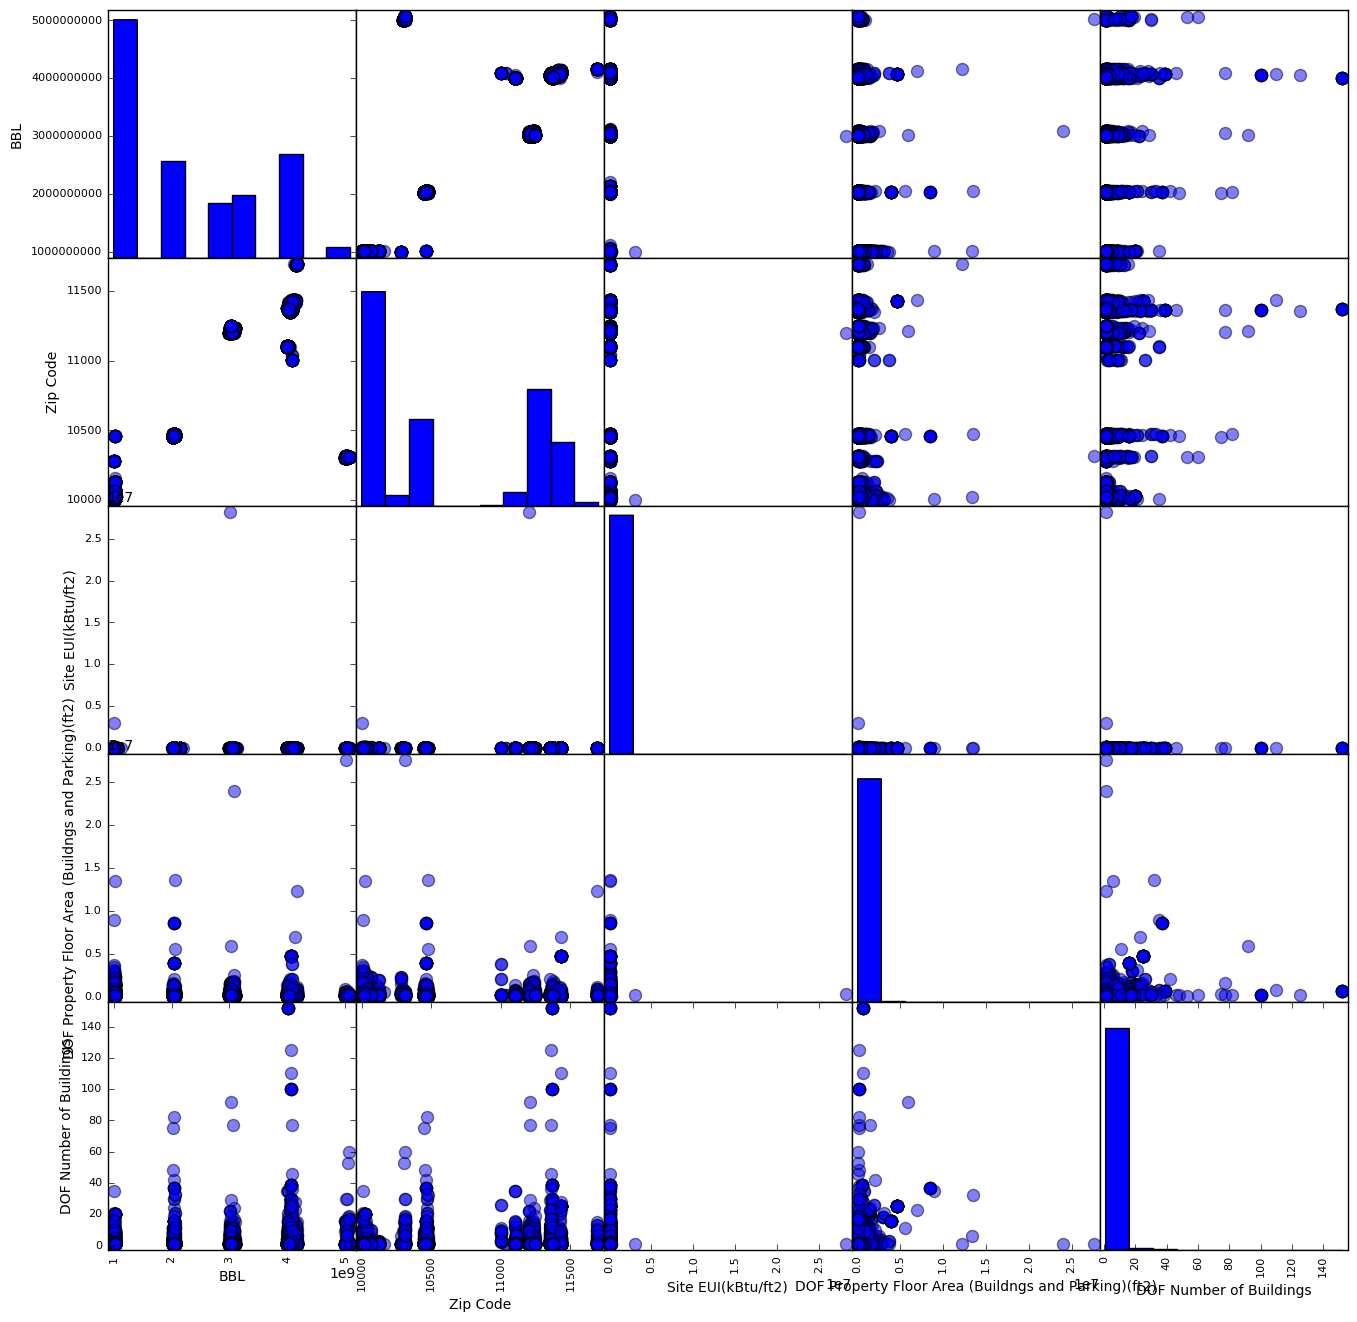

In [60]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [53]:
#converting all entries of nrg to either numerics or NaNs; the values for bsize are already in this format
for col in nrg.columns:
    nrg[col] = pd.to_numeric(nrg[col], errors='coerce')

In [54]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
        


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [59]:
##check that your conversion worked: e.g.
print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [74]:
# prepare your BBL columns
nrg = nrg.rename(index=str,columns={'NYC Borough, Block, and Lot (BBL)':'BBL'})
#merge
bblnrgdata = pd.merge(nrg, bsize, how='outer', on='BBL')
bblnrgdata.columns

Index(['BBL', 'Zip Code', 'Site EUI(kBtu/ft2)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'DOF Number of Buildings', 'UnitsTotal'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96ae8b88d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f96b8be2358>]], dtype=object)

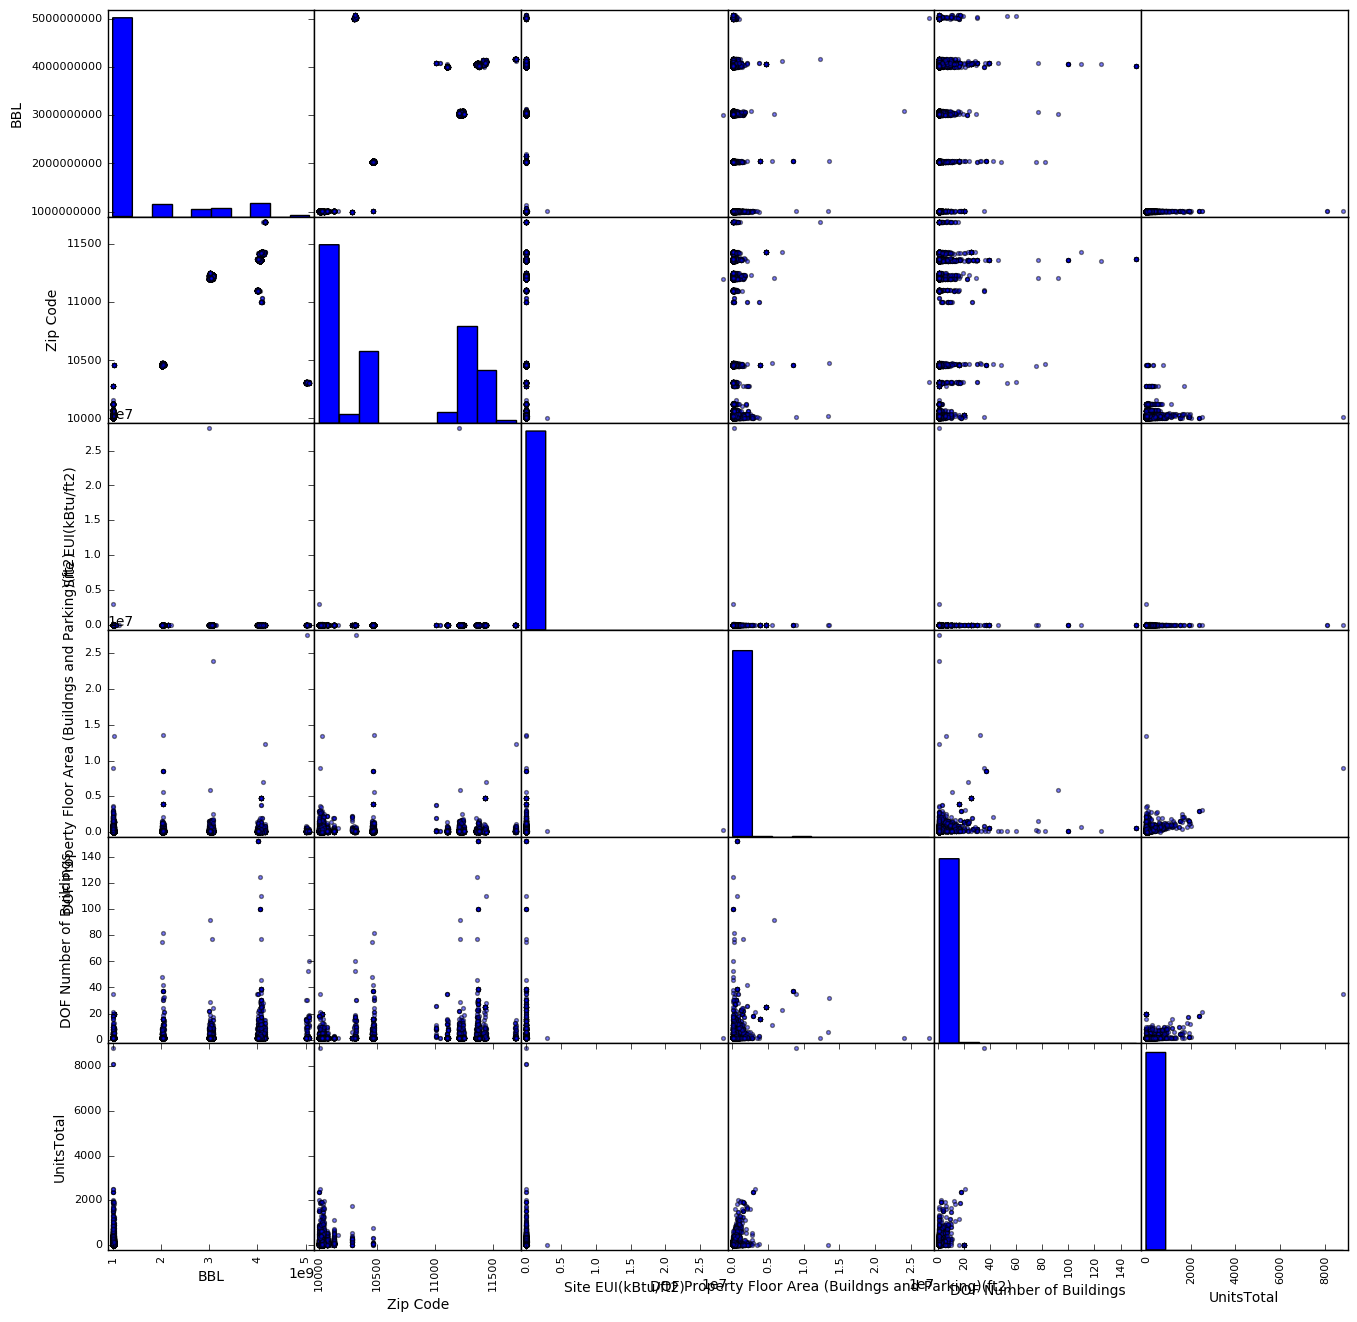

In [75]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

Figure 2: Scatter matrix of all columns in the merged dataframes. The values of all columns are either numeric or NaN, thus all are represented.

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

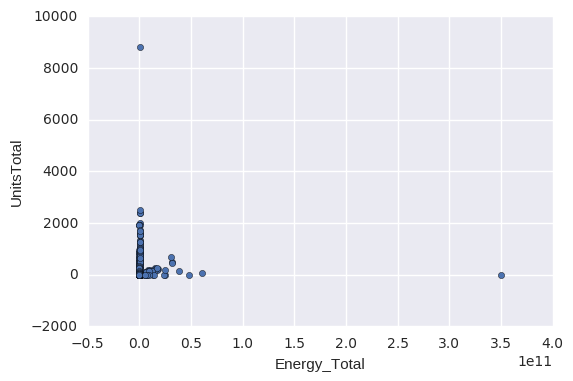

In [181]:
# first scatter plot
bblnrgdata['Energy_Total'] = bblnrgdata['Site EUI(kBtu/ft2)'].multiply(bblnrgdata['DOF Property Floor Area (Buildngs and Parking)(ft2)'])
#DataFrame.multiply(other, axis='columns', level=None, fill_value=None)
bblnrgdata.plot.scatter('Energy_Total', 'UnitsTotal')

Figure 3: Scatter plot of Total Energy Consumption vs. Total Units in the building. Note that the x axis is in units of 1e11. There appear to be a few significant outliers in terms of both energy and units.

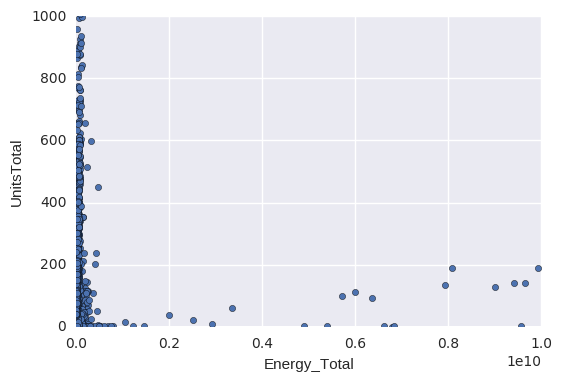

In [182]:
# zoomed in scatter plot
bblnrgdata.plot.scatter('Energy_Total', 'UnitsTotal', xlim=(1000,1e10), ylim=(1,1000))

Figure 4: Scatter plot of Total Energy Consumption vs. Total Units in the building with restricted axes. The Energy_Total values appear to still be compressed near 0 on the x axis.

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



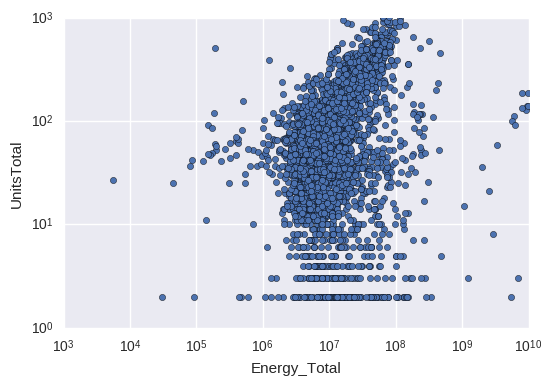

In [183]:
#log plot
bblnrgdata_cut = bblnrgdata[(bblnrgdata['Energy_Total'] > 1000) & (bblnrgdata['Energy_Total'] < 1e10) &
                            (bblnrgdata['UnitsTotal'] > 1) & (bblnrgdata['UnitsTotal'] < 4000)]
bblnrgdata_cut.plot.scatter('Energy_Total', 'UnitsTotal', xlim=(1000,1e10), ylim=(1,1000),loglog=True)

Figure 5: Scatter plot of the log of Total Energy Consumption vs. the log of Total Units in the building with restricted axes. The compression of the Energy_Total values appear to have been resolved. Values of energy below 1000 and above 1e10, and values of units below 1 and above 1000 have been removed as outliers.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:



## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.



1. **Fit a line** to Units vs Energy.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


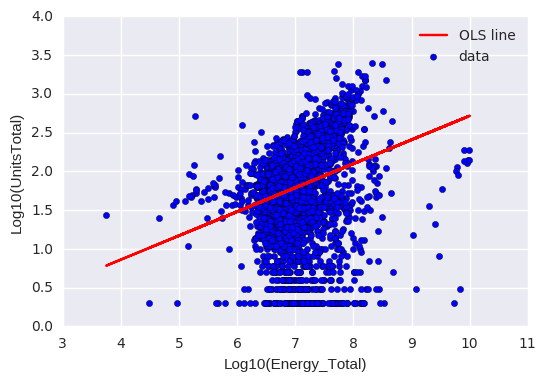

In [203]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

#Run using Energy as IV vs. Units as DV
X = sm.add_constant(np.log10(bblnrgdata_cut['Energy_Total']))
linmodel1 = sm.OLS(np.log10(bblnrgdata_cut['UnitsTotal']), X, missing='drop').fit() # ignores entires 
bblnrgdata_cut['units_pred'] = linmodel1.predict(X) 

pl.scatter(np.log10(bblnrgdata_cut['Energy_Total']), np.log10(bblnrgdata_cut['UnitsTotal']))
pl.plot(np.log10(bblnrgdata_cut['Energy_Total']), bblnrgdata_cut['units_pred'],'r')
pl.xlabel('Log10(Energy_Total)')
pl.ylabel('Log10(UnitsTotal)')
pl.legend(['OLS line','data'])

Figure 6: OLS Regression using Total_Energy as the IV. Total_Energy appears to be clustered around a narrow range of values, making it potentially suboptimal as an IV.

In [185]:
chisq_num = (np.log10(bblnrgdata_cut['UnitsTotal']) - bblnrgdata_cut['units_pred'])**2 
chisq = np.sum(chisq_num / np.abs(np.log10(bblnrgdata_cut['UnitsTotal'])))
chisq

1669.1464269535136

#### Our Chi Squared Statistic is quite high, indicating the possibility of a bad fit

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


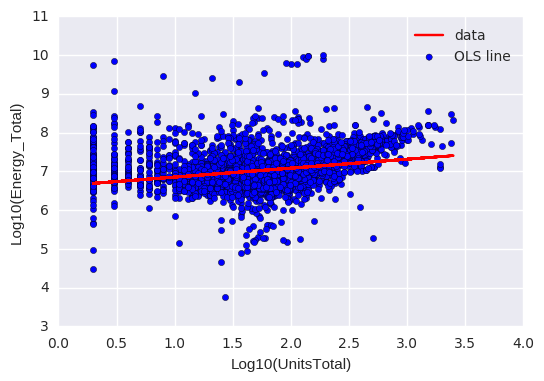

In [202]:
#Run using Units as IV vs. Energy as DV
X = sm.add_constant(np.log10(bblnrgdata_cut['UnitsTotal']))
linmodel2 = sm.OLS(np.log10(bblnrgdata_cut['Energy_Total']), X, missing='drop').fit() # ignores entires 
bblnrgdata_cut['energy_pred'] = linmodel2.predict(X) 

pl.scatter(np.log10(bblnrgdata_cut['UnitsTotal']), np.log10(bblnrgdata_cut['Energy_Total']))
pl.plot(np.log10(bblnrgdata_cut['UnitsTotal']), bblnrgdata_cut['energy_pred'],'r')
pl.xlabel('Log10(UnitsTotal)')
pl.ylabel('Log10(Energy_Total)')
pl.legend(['OLS line','data'])

Figure 7: OLS regression using UnitsTotal as the independent variable. The regression line appears to capture much more of the structure of the data than the previous figure

In [187]:
chisq_num = (np.log10(bblnrgdata_cut['Energy_Total']) - bblnrgdata_cut['energy_pred'])**2 
chisq = np.sum(chisq_num / np.abs(np.log10(bblnrgdata_cut['Energy_Total'])))
chisq

117.07138535478636

#### As the Chi Squared Statistic with 'UnitsTotal' as the independent value is much lower than the respective statistic when 'Energy_Total' is the independent value, we can conclude that the second model is a better fit (i.e. Higher Chi squared values indicate that the model is farther away from the actual data)

In [188]:
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Energy_Total   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     332.5
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           1.23e-71
Time:                        19:38:41   Log-Likelihood:                -2592.1
No. Observations:                4329   AIC:                             5188.
Df Residuals:                    4327   BIC:                             5201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.6211      0.024    278.880      0.000         6.575     6.668
UnitsTotal     0.2307      0.013     18.235      0.000         0.206     0.256
==============================================================================
Omnibus:                     1203.739   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12015.158
Skew:                           1.034   Prob(JB):                         0.00
Kurtosis:                      10.895   Cond. No.                         8.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Quadratic Fit Model:

In [189]:
#Add in a column for UnitsTotal ** 2
bblnrgdata_cut['UT2'] = bblnrgdata_cut['UnitsTotal']**2

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [199]:
quadmodel = smf.ols(formula='np.log(Energy_Total) ~ UnitsTotal + UT2', data=bblnrgdata_cut).fit()
quadmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Energy_Total)   R-squared:                       0.201
Model:                              OLS   Adj. R-squared:                  0.201
Method:                   Least Squares   F-statistic:                     545.4
Date:                  Sun, 16 Oct 2016   Prob (F-statistic):          5.70e-212
Time:                          19:47:58   Log-Likelihood:                -5876.1
No. Observations:                  4329   AIC:                         1.176e+04
Df Residuals:                      4326   BIC:                         1.178e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.7546      0.020    771.287      0.000        15.715    15.795
UnitsTotal     0.0044      0.000     28.105      0.000         0.004     0.005
UT2        -1.545e-06   1.08e-07    -14.330      0.000     -1.76e-06 -1.33e-06
==============================================================================
Omnibus:                     1475.671   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22928.550
Skew:                           1.199   Prob(JB):                         0.00
Kurtosis:                      14.016   Cond. No.                     3.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
print ("LR : ", -2 * (-linmodel2.llf - (-quadmodel.llf)))
print ("LR from statsmodels:", quadmodel.compare_lr_test(linmodel2))

LR :  6568.07992651
LR from statsmodels: (-6568.0799265088535, 1.0, 1.0)


### As there is one more parameter in the quadrature model compared with the linear model, the LR is chi squared with 1 degree of freedom, thus the critical value for a reasonable alpha of 0.05 is 3.84. As our LR statistic is far beyond that threshold at 6568, we can conclude that the simpler linear model is preferrable to the more complex quadrature model.

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

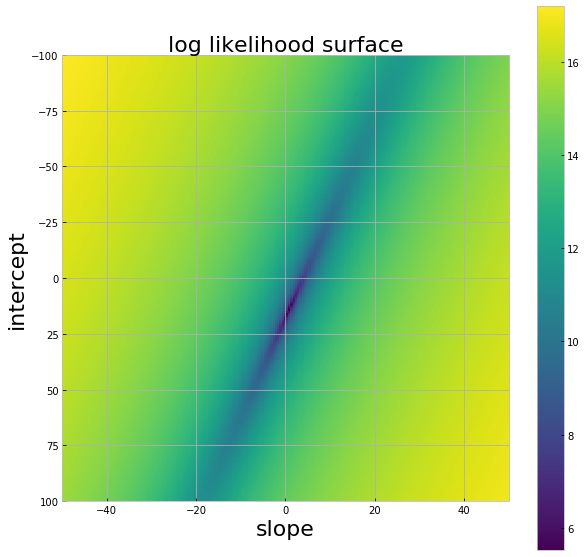

In [42]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,0,'total energy consumption (kBtu)')

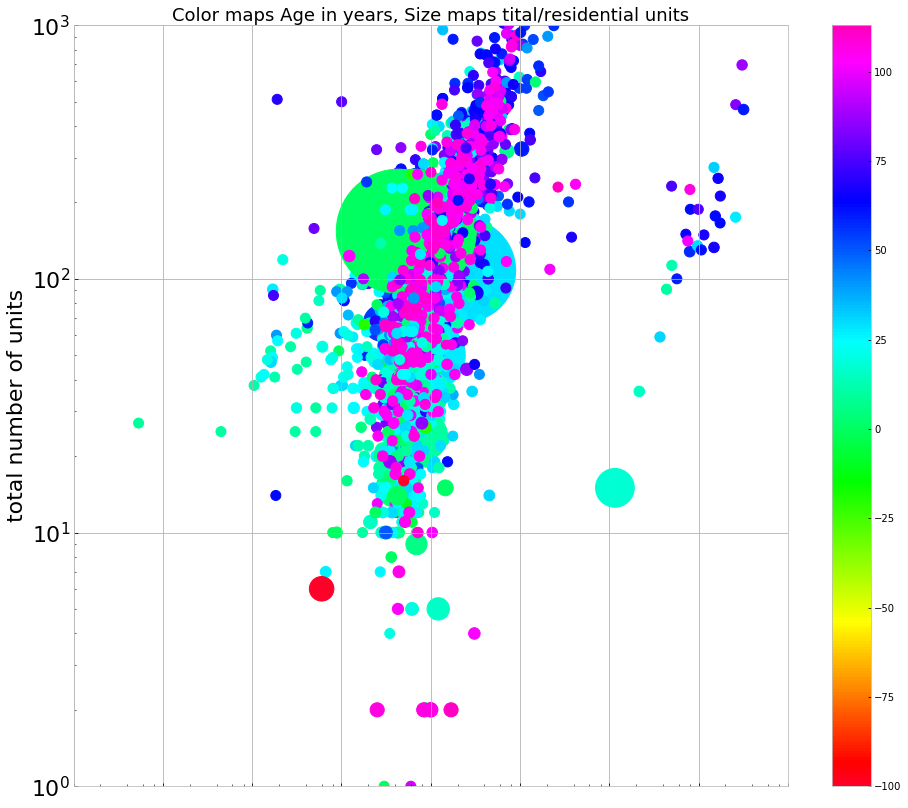

In [49]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)